# Uso de índice de silohoutte

**Autor:** Jazna Meza Hidalgo

**Correo Electrónico:** ja.meza@profesor.duoc.cl

**Fecha de Actualziación:** Junio 2024

**Versión:** 1.0

**Fecha de Actualziación:** Enero de 2025

**Versión:** 1.1  

---

## Descripción

Este notebook contiene la explicación del uso del índice de silohoutte como métrica en problemas de segmentación.

Utiliza un dataset de clientes de una institución financiera (banco).

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.9. A continuación se listan las bibliotecas necesarias:

- pandas (>=1.1.0)
- numpy (1.26.4)
- matplotlib (3.7.1)
- seaborn (0.13.1)
- sklearn

Para verificar la versión instalada ejecutar usando el siguiente comando, usando la librería de la cual quieres saber la versión:

```bash
import pandas as pd
print(pd.__version__)
````

# Segmentación de clientes bancarios

En este núcleo realizaremos la segmentación de clientes de los bancos alemanes.  


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score

In [4]:
!wget https://raw.githubusercontent.com/JaznaLaProfe/Mineria_de_datos/main/datos/german_credit_data.csv

--2025-01-20 01:26:49--  https://raw.githubusercontent.com/JaznaLaProfe/Mineria_de_datos/main/datos/german_credit_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49689 (49K) [text/plain]
Saving to: ‘german_credit_data.csv’

german_credit_data. 100%[===================>]  48.52K  --.-KB/s    in 0.01s   

2025-01-20 01:26:50 (3.97 MB/s) - ‘german_credit_data.csv’ saved [49689/49689]



In [18]:
data = pd.read_csv("german_credit_data.csv")

Control visual de las primeras filas

In [19]:
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


Parece que la primera columna es simplemente un índice que podemos eliminar. Verificaremos cuántos valores faltantes hay en cada columna y de qué tipos de datos son.

In [20]:
data.drop(data.columns[0], inplace=True, axis=1)
print("Conjunto tiene {} observaciones (customers) y {} caracter´siticas (attributes).".format(data.shape[0],data.shape[1]))
print("*"*15,"\nValores nulos en cada columna:\n{}".format(data.isnull().sum()))
print("*"*15,"\nTipos de datos:\n{}".format(data.dtypes))

Conjunto tiene 1000 observaciones (customers) y 9 caracter´siticas (attributes).
*************** 
Valores nulos en cada columna:
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64
*************** 
Tipos de datos:
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
dtype: object


De 8 columnas, 2 contienen valores faltantes. Probablemente se trate de clientes que no tengan ninguna de estas dos cuentas.

Se puede indicar, de forma preliminar, que existen 3 variables numéricas y 5 categóricas.

Ahora, se comprueba cuántos y cuáles son los valores posibles (únicos) en cada columna categórica.

In [21]:
n_unique = data.nunique()
print("Número de valores únicos:\n{}".format(n_unique))

Número de valores únicos:
Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
dtype: int64


In [22]:
print("Valores únicos para cada columna categórica")
for col in data.select_dtypes(include=[object]):
  print(col,":", data[col].unique())

Valores únicos para cada columna categórica
Sex : ['male' 'female']
Housing : ['own' 'free' 'rent']
Saving accounts : [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account : ['little' 'moderate' nan 'rich']
Purpose : ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


**Análisis exploratorio de datos**

A continuación se define una función que generará gráficos para tres variables numéricas con estratificación por columna categórica seleccionada.

In [23]:
def scatters(data : pd.DataFrame, h=None, pal=None):
  fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
  sns.scatterplot(x="Credit amount",y="Duration", hue=h, palette=pal, data=data, ax=ax1)
  sns.scatterplot(x="Age",y="Credit amount", hue=h, palette=pal, data=data, ax=ax2)
  sns.scatterplot(x="Age",y="Duration", hue=h, palette=pal, data=data, ax=ax3)
  plt.tight_layout()

Se inicia con los diagramas de dispersión de nuestras 3 variables numéricas estratificadas por sexo.

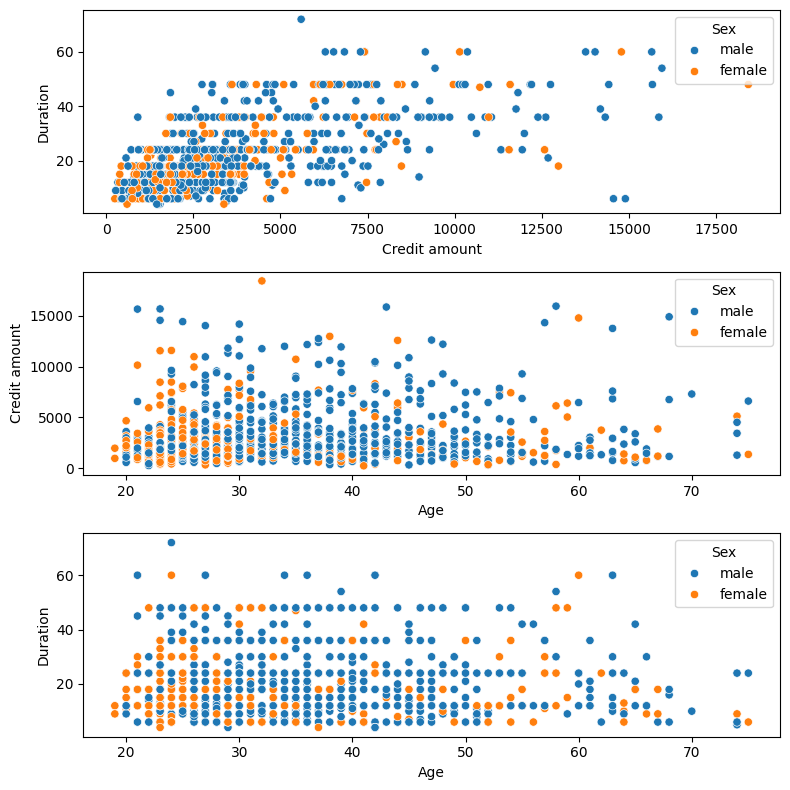

In [24]:
scatters(data, h="Sex")

La impresión general es que las mujeres tienden a ser más jóvenes que los hombres, sin embargo, el gráfico superior muestra que no hay una diferencia clara entre hombres y mujeres en términos de monto y duración del crédito. A partir de una inspección visual, parece que existe cierta correlación positiva entre la duración y el monto del crédito, lo que tiene sentido.

Ahora, se comprueba la correlación lineal entre el importe del crédito y la duración.

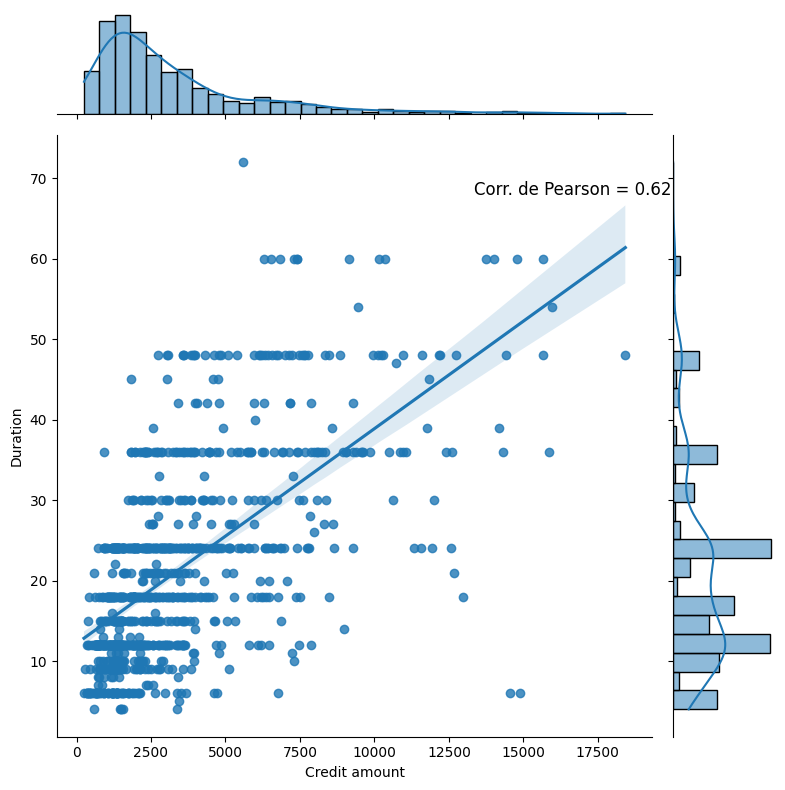

In [26]:
# Crear el jointplot
r1 = sns.jointplot(x="Credit amount", y="Duration", data=data, kind="reg", height=8)

# Calcular la correlación de Pearson
pearson_corr, _ = stats.pearsonr(data["Credit amount"], data["Duration"])

# Anotar el gráfico con la correlación de Pearson
r1.ax_joint.annotate(f"Corr. de Pearson = {pearson_corr:.2f}", xy=(0.7, 0.9),
                     xycoords="axes fraction", fontsize=12)

# Mostrar el gráfico
plt.show()


El gráfico anterior muestra una correlación lineal con el valor de Pearson de 0,62 y un valor p muy pequeño. Esto tiene sentido porque, por lo general, las personas obtienen créditos más grandes por períodos más largos. A continuación se analizan gráficos de regresión lineal con varias categorizaciones.

In [27]:
data[["Credit amount", "Duration"]].corr().round(2)

,Credit amount,Duration
Credit amount,1.00,0.62
Duration,0.62,1.00


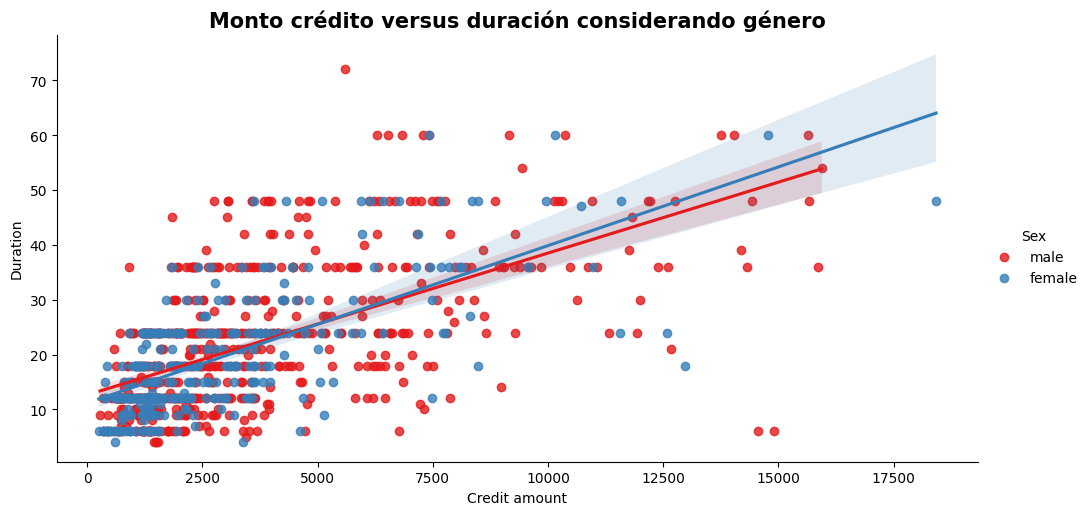

In [28]:
sns.lmplot(x="Credit amount",y="Duration", hue="Sex", data=data, palette="Set1", aspect=2)
plt.title("Monto crédito versus duración considerando género", fontsize=15, fontweight="bold")
plt.show()

El gráfico anterior indica que no hay una diferencia significativa entre hombres y mujeres.

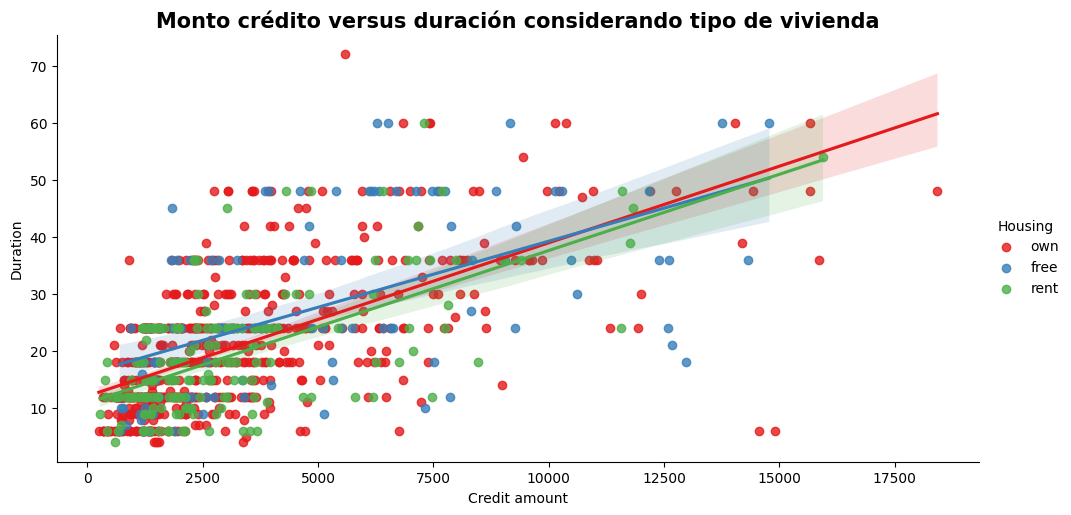

In [29]:
sns.lmplot(x="Credit amount",y="Duration", hue="Housing", data=data, palette="Set1", aspect=2)
plt.title("Monto crédito versus duración considerando tipo de vivienda", fontsize=15, fontweight="bold")
plt.show()

El gráfico anterior muestra de manera similar que no hay diferencias entre las categorías de vivienda.
A continuación se muestra el área de “negocios” donde se otorga la mayor cantidad de créditos.

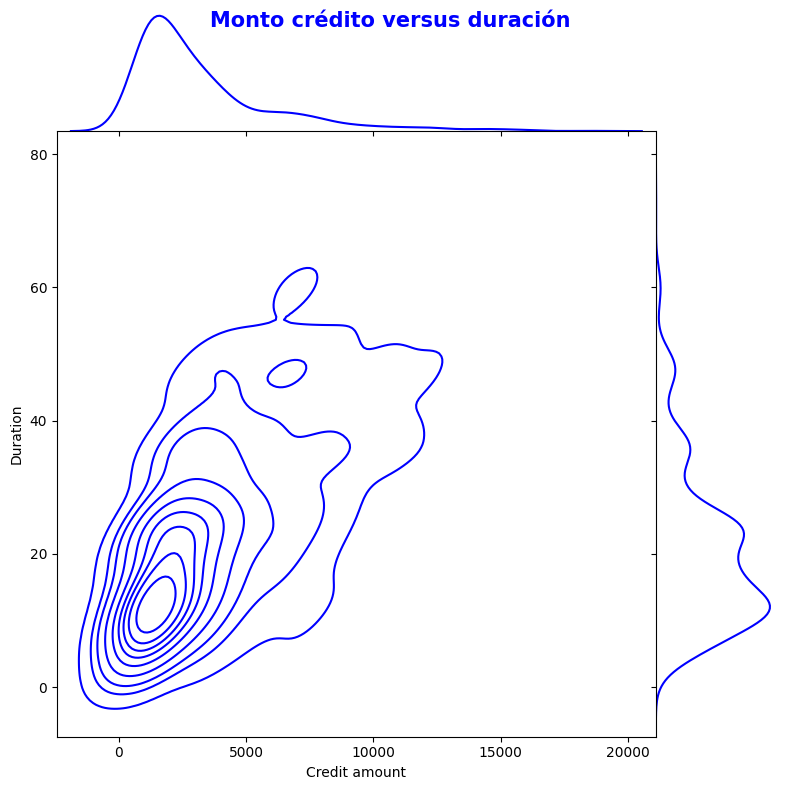

In [30]:
sns.jointplot(x="Credit amount", y="Duration", data=data, kind="kde",
              space=0, color="b", height=8)
plt.suptitle("Monto crédito versus duración", fontsize=15, color = "blue", fontweight="bold")
plt.show()


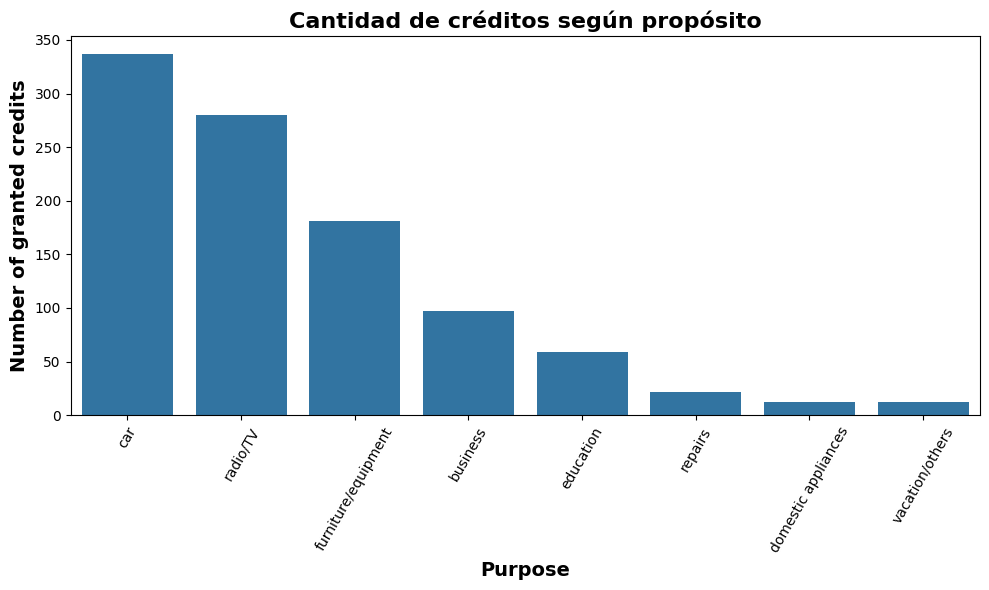

In [31]:
n_credits = data.groupby("Purpose")["Age"].count().rename("Count").reset_index()
n_credits.sort_values(by=["Count"], ascending=False, inplace=True)

plt.figure(figsize=(10,6))
bar = sns.barplot(x="Purpose",y="Count",data=n_credits)
bar.set_xticklabels(bar.get_xticklabels(), rotation=60)
plt.xlabel("Purpose", fontsize=14, fontweight="bold")
plt.ylabel("Number of granted credits", fontsize=14, fontweight="bold")
plt.title("Cantidad de créditos según propósito", fontsize=16, fontweight="bold")
plt.tight_layout()

El diagrama de barras anterior muestra cuántos créditos se otorgaron para diversos fines. La mayoría de los créditos se concedieron para automóviles y radio/TV.

Ahora se generan diagramas de caja para un análisis detallado de variables categóricas.

In [32]:
def boxes(x : str, y : str, h : str,r=45):
  fig, ax = plt.subplots(figsize=(10,6))
  box = sns.boxplot(x=x,y=y, hue=h, data=data)
  box.set_xticklabels(box.get_xticklabels(), rotation=r)
  fig.subplots_adjust(bottom=0.2)
  plt.title(f"Análisis de variables {x}-{y}-{h}", fontsize=16, fontweight="bold")
  plt.tight_layout()

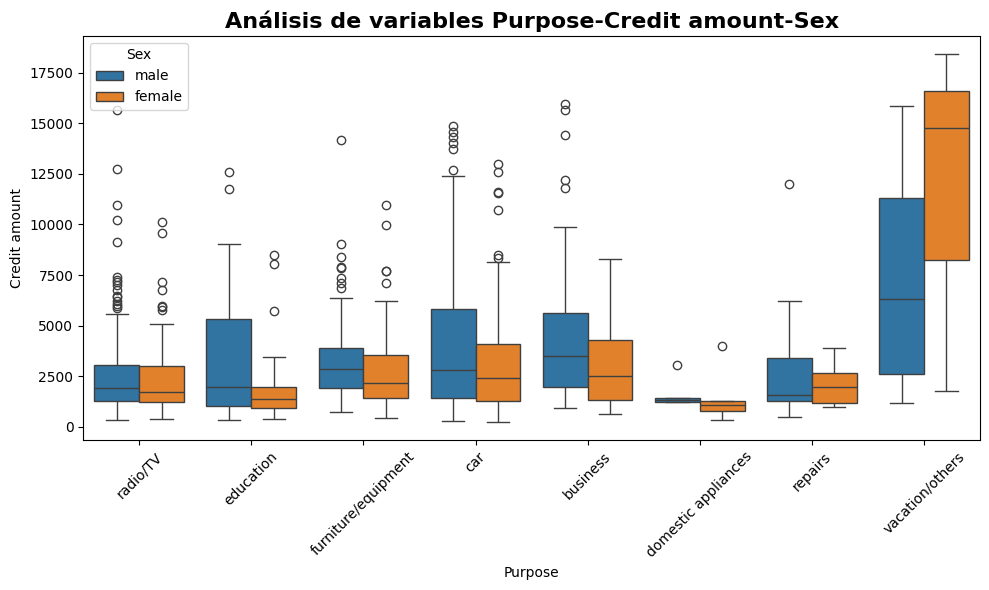

In [33]:
boxes("Purpose","Credit amount","Sex")

El gráfico anterior muestra que las cantidades más grandes se toman para vacaciones/otros, y las más pequeñas para electrodomésticos. La mayoría de ellos tienen valores atípicos en la parte superior de los cuadros (cantidades más altas). En la mayoría de los casos no hay diferencia entre hombres y mujeres, a pesar de la categoría vacaciones/otros. Sin embargo, hay que recordar que hubo muy pocos créditos concedidos en esta categoría.

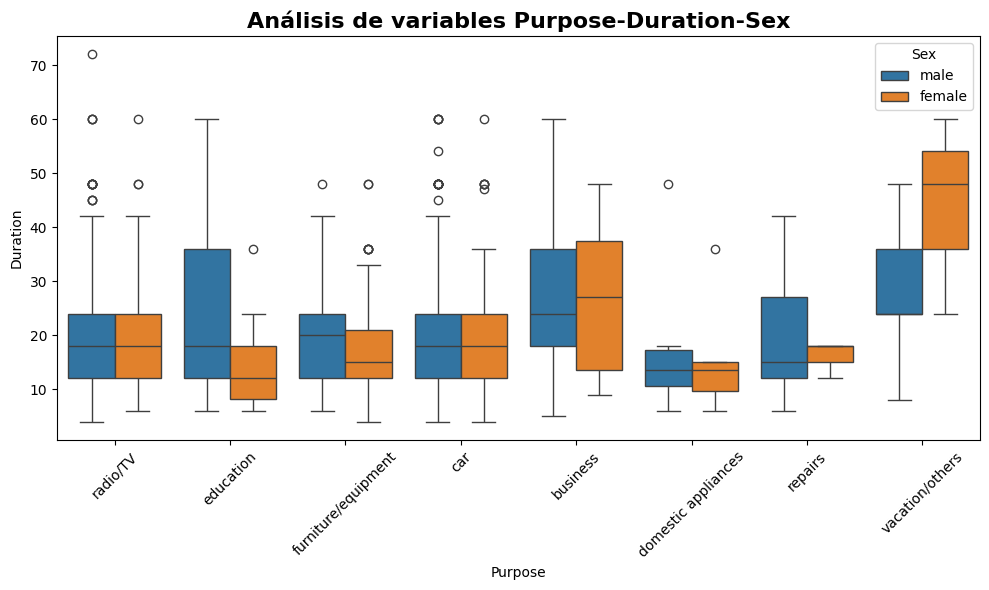

In [34]:
boxes("Purpose","Duration","Sex")

El diagrama de caja anterior indica que, en general, no hay diferencia en la duración del crédito entre hombres y mujeres. No se puede ver tampoco una tendencia clara entre categorías con observaciones de que la duración más corta es para los electrodomésticos. Tiene sentido ya que está de acuerdo con las ideas del gráfico anterior (cantidad de crédito): en esta categoría se encuentran las cantidades más bajas de créditos.

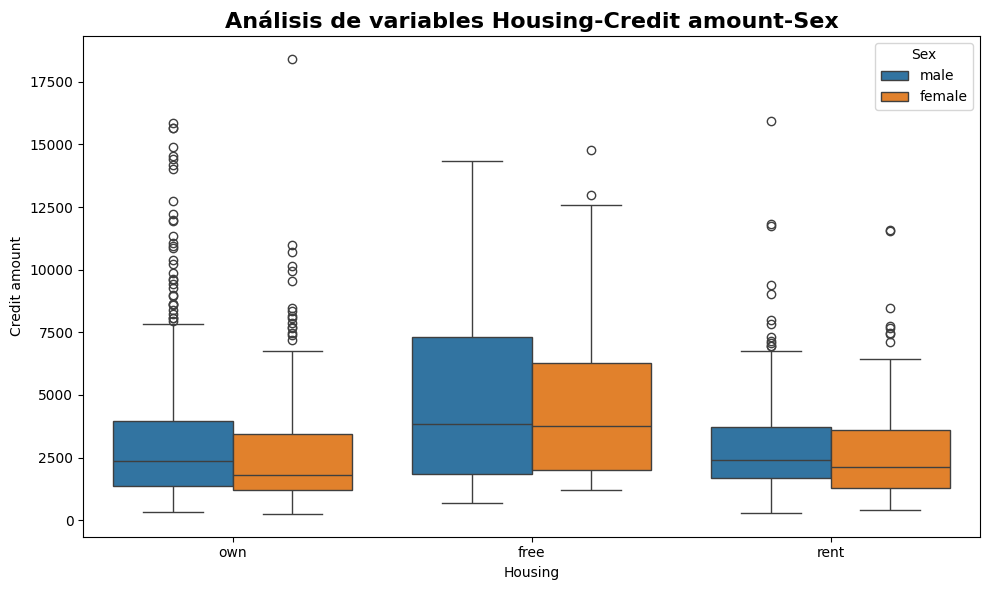

In [35]:
boxes("Housing","Credit amount","Sex",r=0)

En términos de categoría de vivienda, no hay gran diferencia a pesar de que las personas que tienen una vivienda “gratuita” tienden a solicitar montos de crédito ligeramente mayores.

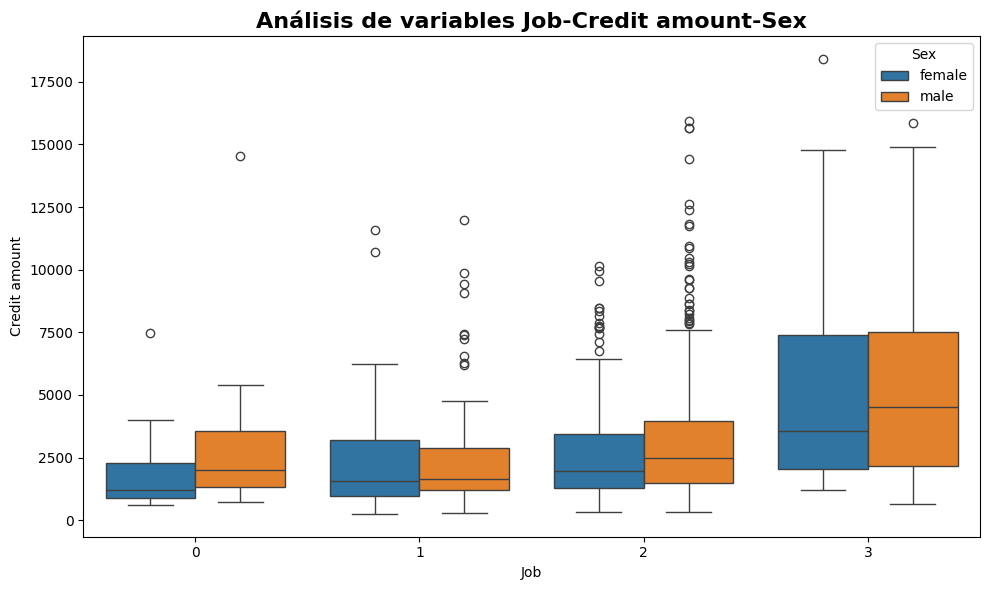

In [36]:
boxes("Job","Credit amount","Sex",r=0)

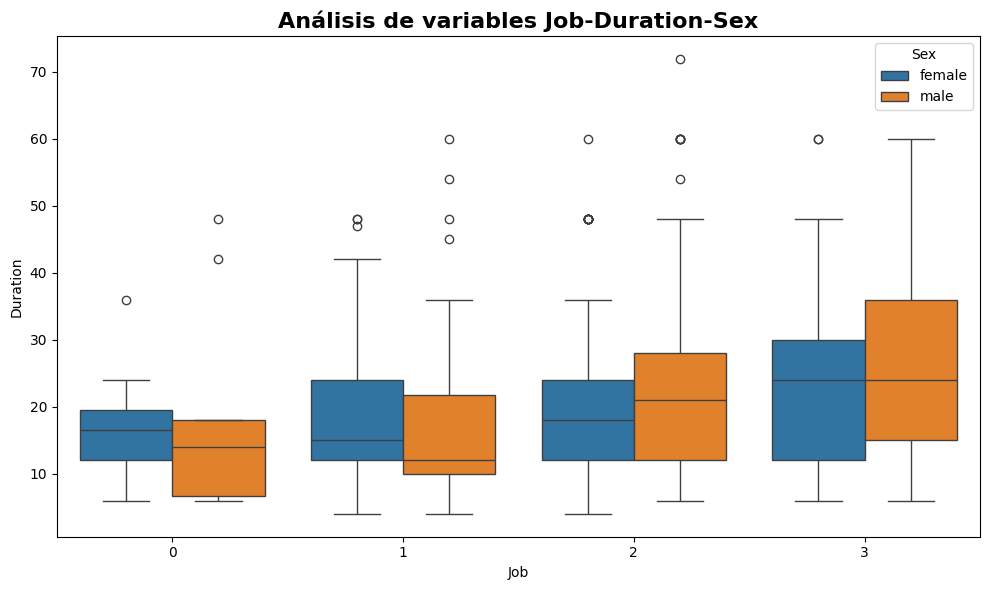

In [37]:
boxes("Job","Duration","Sex",r=0)

En términos de categoría laboral, una vez más no hay diferencia entre hombres y mujeres; sin embargo, es posible ver que la categoría laboral 3 tiende a aceptar montos de crédito mayores por mayor duración.



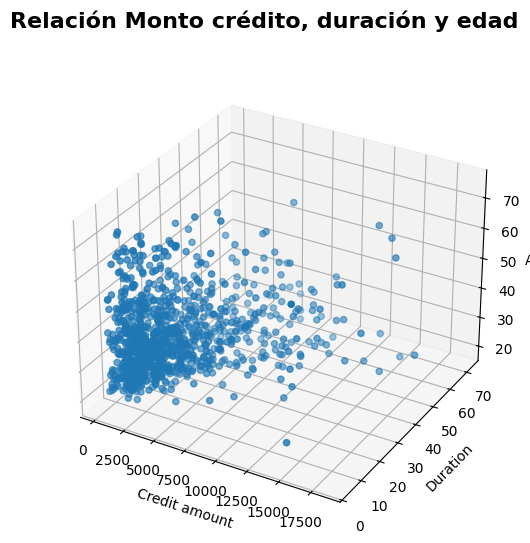

In [38]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data["Credit amount"], data["Duration"], data["Age"])
ax.set_xlabel("Credit amount")
ax.set_ylabel("Duration")
ax.set_zlabel("Age")
plt.suptitle("Relación Monto crédito, duración y edad", fontsize=16, fontweight="bold")
plt.show()

#Agrupación con KMeans

Para la agrupación, se creará un subconjunto que contenga sólo variables numéricas (edad, monto del crédito, duración).

In [39]:
# Selecting columns for clusterisation with k-means
selected_cols = ["Age","Credit amount", "Duration"]
cluster_data = data.loc[:,selected_cols]

Se creará una función que traza tres histogramas, uno para cada variable.

In [40]:
def distributions(df : pd.DataFrame):
  fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
  fig.suptitle("Distribuciones", fontsize=16, fontweight="bold")
  sns.distplot(df["Age"], ax=ax1)
  sns.distplot(df["Credit amount"], ax=ax2)
  sns.distplot(df["Duration"], ax=ax3)
  plt.tight_layout()
  plt.subplots_adjust(top=0.85)

Visluzación de los histogramas

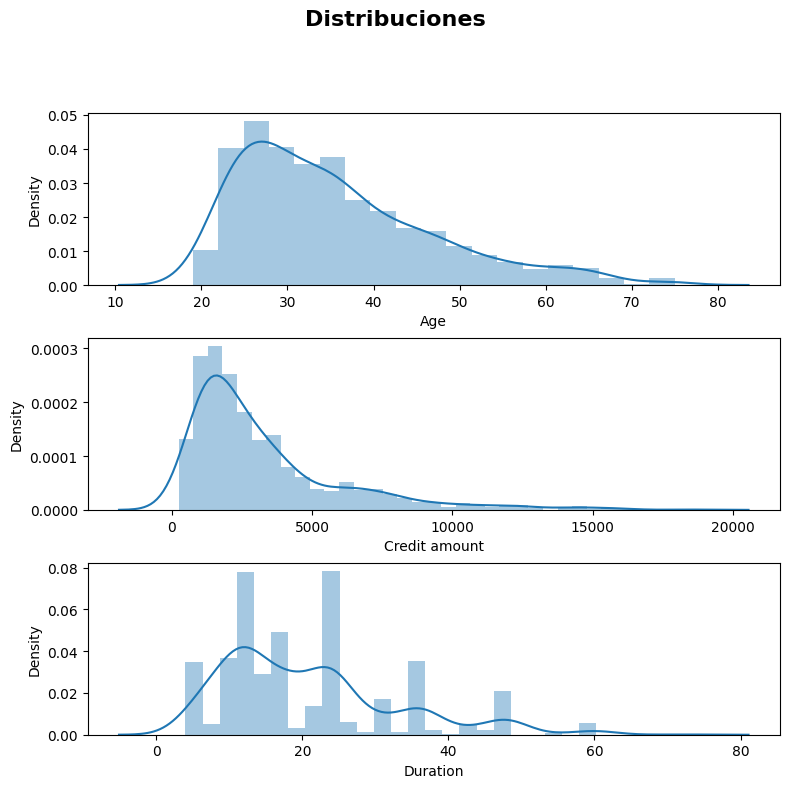

In [41]:
distributions(cluster_data)

Es posible ver que las distribuciones están sesgadas hacia la derecha. Para obtener mejores resultados se debe eliminar la asimetría mediante transformación logarítmica. Después de eso se analiza cómo quedan.

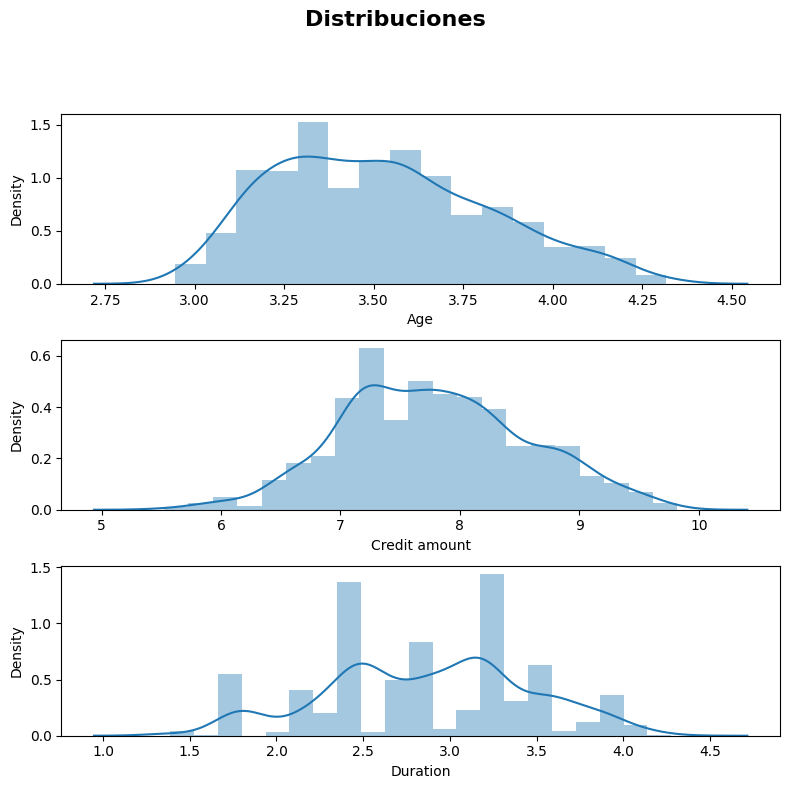

In [42]:
cluster_log = np.log(cluster_data)
distributions(cluster_log)

De hecho, se ha eliminado la asimetría.

El siguiente paso será centrar y escalar las variables; esto lo requiere el algoritmo KMeans. Se usará para eso StandardScaler de la biblioteca sklearn.

In [43]:
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_log)

Se revisa cómo cambia la inercia para varios grupos.

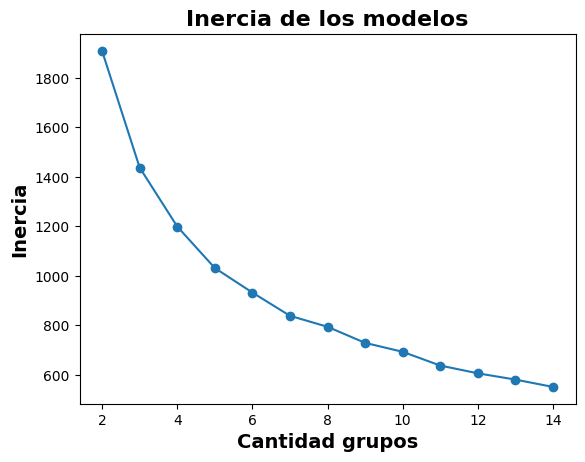

In [46]:
clusters_range = range(2,15)
inertias =[]

for c in clusters_range:
  kmeans = KMeans(n_clusters=c, random_state=0).fit(cluster_scaled)
  inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(clusters_range,inertias, marker='o')
plt.title("Inercia de los modelos", fontsize=16, fontweight="bold")
plt.xlabel("Cantidad grupos", fontsize=14, fontweight="bold")
plt.ylabel("Inercia", fontsize=14, fontweight="bold")
plt.show()

El gráfico anterior muestra que la inercia disminuye a medida que aumenta el número de grupos.

Este método permite evaluar las separaciones de los conglomerados y ajustar cada observación en su propio conglomerado. Cuanto más alto sea el puntaje, mejor. También se va a realizar este análisis para varias semillas.

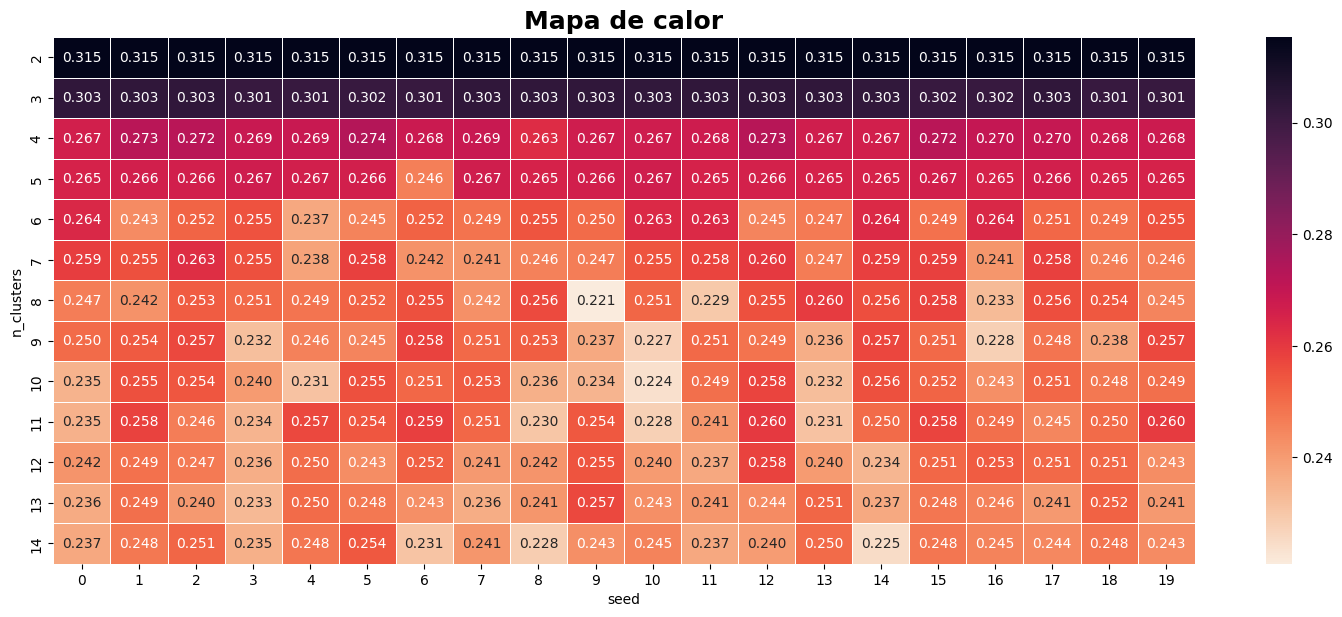

In [47]:
clusters_range = range(2,15)
random_range = range(0,20)
results =[]
for c in clusters_range:
    for r in random_range:
        clusterer = KMeans(n_clusters=c, random_state=r)
        cluster_labels = clusterer.fit_predict(cluster_scaled)
        silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
        #print("For n_clusters =", c," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)
        results.append([c,r,silhouette_avg])

result = pd.DataFrame(results, columns=["n_clusters","seed","silhouette_score"])
pivot_km = pd.pivot_table(result, index="n_clusters", columns="seed",values="silhouette_score")

plt.figure(figsize=(15,6))
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r)
plt.tight_layout()
plt.title("Mapa de calor", fontsize=18, fontweight="bold");

El mapa de calor anterior muestra puntuaciones de Silhouette para varias combinaciones de estado aleatorio y número de grupos.

Los puntajes más altos son para racimos 2 y 3 y son relativamente insensibles a la semilla.

Se elegirán 3 grupos para obtener más información sobre los datos.

In [48]:
kmeans_sel = KMeans(n_clusters=3, random_state=29).fit(cluster_scaled)
labels = pd.DataFrame(kmeans_sel.labels_)
clustered_data = cluster_data.assign(Cluster=labels)

A continuación, se crea un gráfico de Silhouette para 3 grupos para representar visualmente el ajuste de cada punto dentro de su propio grupo (código modificado del documento scikit-learn).

Para n_clusters = 3  y seed = 19 
El promedio silhouette_score es : 0.301686616517302


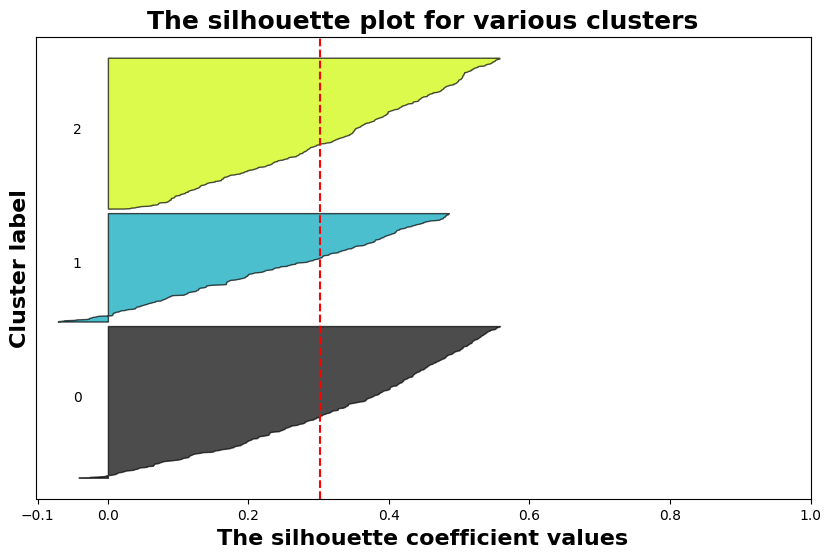

In [50]:
clusterer = KMeans(n_clusters=3, random_state=29)
cluster_labels = clusterer.fit_predict(cluster_scaled)
silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
print("Para n_clusters =", 3," y seed =", r,  "\nEl promedio silhouette_score es :", silhouette_avg)

# Calcula el índice de silohoutte para cada ejemplo
sample_silhouette_values = silhouette_samples(cluster_scaled, cluster_labels)

fig, ax1 = plt.subplots(figsize=(10,6))

y_lower = 10
for i in range(3):
  # Agrega el índice calculado para el i.ésimo cluster y ordena
  ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
  ith_cluster_silhouette_values.sort()

  size_cluster_i = ith_cluster_silhouette_values.shape[0]
  y_upper = y_lower + size_cluster_i

  color = cm.nipy_spectral(float(i) / 3)
  ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values, facecolor=color, edgecolor="black", alpha=0.7)

  # Label the silhouette plots with their cluster numbers at the middle
  ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

  # Compute the new y_lower for next plot
  y_lower = y_upper + 10  # 10 for the 0 samples

ax1.get_yaxis().set_ticks([])
ax1.set_title("The silhouette plot for various clusters", fontsize=18, fontweight="bold")
ax1.set_xlabel("The silhouette coefficient values", fontsize=16, fontweight="bold")
ax1.set_ylabel("Cluster label", fontsize=16, fontweight="bold")
# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]);

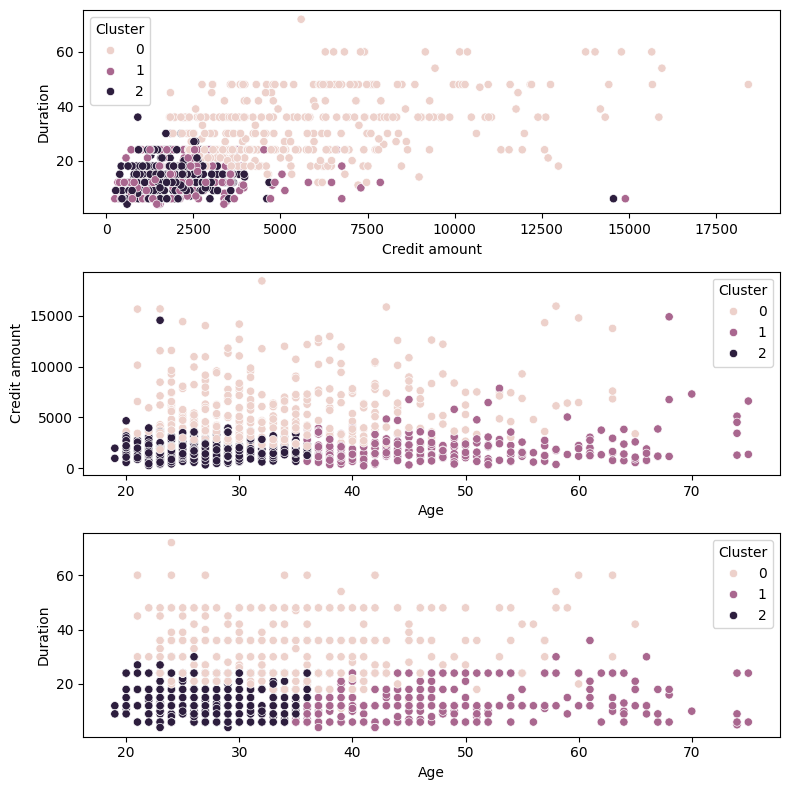

In [51]:
scatters(clustered_data, 'Cluster')

Los gráficos de arriba muestran tres grupos creados. En los gráficoss inferiores muestran una separación de grupos relativamente clara, pero no es tan evidente en el superior.

Ahora se genera un gráfico de mapa de calor para facilitar la interpretación empresarial de la segmentación de clientes.

In [52]:
clustered_data

,Age,Credit amount,Duration,Cluster
0,67,1169,6,1
1,22,5951,48,0
2,49,2096,12,1
3,45,7882,42,0
4,53,4870,24,0
...,...,...,...,...
995,31,1736,12,2
996,40,3857,30,0
997,38,804,12,1
998,23,1845,45,0


In [53]:
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)
grouped_km

,Age,Credit amount,Duration
Cluster,,,
0,34.3,5724.1,32.3
1,48.3,1947.5,13.6
2,27.6,1757.3,14.6


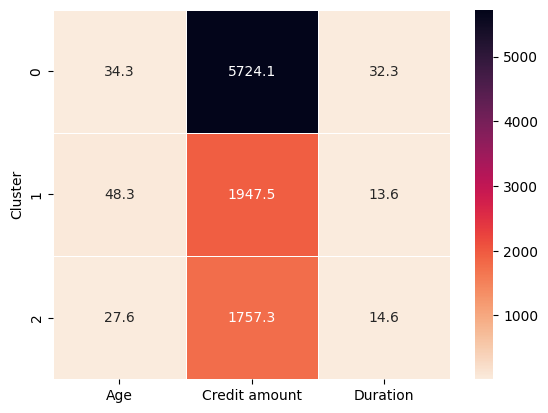

In [54]:
sns.heatmap(grouped_km, annot=True, linewidths=.5, fmt='.1f', cmap=sns.cm.rocket_r);